# Implementation of ResNet18

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

print(torch.__version__)

2.1.2


## device related functions

In [2]:
def num_gpus():
    """Get the number of GPUs."""
    if torch.cuda.is_available():
        return torch.cuda.device_count()
    return 0


def try_gpu(i=0):
    if num_gpus() > i:
        return torch.device(f"cuda:{i}")
    else:
        print(f"gpu with index '{i}' is not available")
        return torch.device("cpu")


def try_all_gpus():
    """
    Return all available GPUs, or [cpu(),] if no GPU exists.

    Returns:
    -------
    devices: list
        A list of devices.
    """

    return [torch.device(f"cuda:{i}") for i in range(num_gpus())]


def gpus_info(gpu_list):
    for i, gpu in enumerate(gpu_list):
        print(f"""gpu {i}: {torch.cuda.get_device_name(gpu)}""")


def current_gpu_info():
    current_device = torch.cuda.current_device()
    print(f"""current gpu : {torch.cuda.get_device_name(current_device)}""")


try_gpu(2)
gpu_list = try_all_gpus()
gpus_info(gpu_list)

torch.cuda.set_device(0)
current_gpu_info()

tensor_A = torch.tensor([1,2,3]).to(try_gpu(0))
device = tensor_A.device
print(device)


gpu with index '2' is not available
gpu 0: NVIDIA GeForce GTX 1650
current gpu : NVIDIA GeForce GTX 1650
cuda:0


## ResNet

### the Residual Block

![The ResNet-18 architecture.](..\materials\images\resnet-block.svg)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super(ResidualBlock, self).__init__()
        self.convolution_layer_1 = nn.LazyConv2d(
            num_channels, kernel_size=3, padding=(1, 1), stride=strides
        )
        self.convolution_layer_2 = nn.LazyConv2d(
            num_channels, kernel_size=3, padding=(1, 1)
        )

        if use_1x1conv:
            self.convolution_layer_3 = nn.LazyConv2d(
                num_channels, kernel_size=1, stride=strides
            )
        else:
            self.convolution_layer_3 = None
            
        self.batch_norm_layer_1 = nn.LazyBatchNorm2d()
        self.batch_norm_layer_2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.batch_norm_layer_1(self.convolution_layer_1(X)))
        Y = self.batch_norm_layer_2(self.convolution_layer_2(Y))
        if self.convolution_layer_3:
            X = self.convolution_layer_3(X)
        Y += X
        return F.relu(Y)

In [4]:
residual_block_1 = ResidualBlock(3) # a residual block with 3 output channels
block_input = torch.rand(4,3,6,6) # 4 samples each with 3 channels whose width*height is 6*6
residual_block_1(block_input).shape

f:\anaconda\envs\FYP\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [5]:
# use the 1x1conv to adjust the original data
residual_block_2 = ResidualBlock(10, use_1x1conv=True) # a residual block with 10 output channels
block_input = torch.rand(4,3,6,6) # 4 samples each with 3 channels whose width*height is 6*6
residual_block_2(block_input).shape

torch.Size([4, 10, 6, 6])

### the whole model

![The ResNet-18 architecture.](../materials\images\resnet18-90.svg)

In [6]:
class ResNet(nn.Module):
    def __init__(self, shape):
        super(ResNet, self).__init__()
        self.input_shape = shape
        self.net = nn.Sequential(
            self.part_1(),  # conv and pooling
            self.part_2(),  # residual blocks
            self.part_3(),  # global pooling and dense layer
        )
        self._initialize_weights()
        self.to(try_gpu())

    def part_1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            # nn.LazyConv2d(32, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def part_2(self):
        return nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(128, use_1x1conv=True, strides=2),
            ResidualBlock(128),
            ResidualBlock(256, use_1x1conv=True, strides=2),
            ResidualBlock(256),
            ResidualBlock(512, use_1x1conv=True, strides=2),
            ResidualBlock(512),
            
        #     ResidualBlock(32),
        #     ResidualBlock(32),
        #     ResidualBlock(64, use_1x1conv=True, strides=2),
        #     ResidualBlock(64),
        #     ResidualBlock(128, use_1x1conv=True, strides=2),
        #     ResidualBlock(128),
        #     ResidualBlock(256, use_1x1conv=True, strides=2),
        #     ResidualBlock(256),
        
        )

    def part_3(self):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(10),
            # nn.Softmax(dim=1), # can be removed if loss function is CrossEntropyLoss
        )

    def _initialize_weights(self):
        # Initialize weights by running a dummy forward pass
        dummy_input = torch.randn(*self.input_shape)
        _ = self.forward(dummy_input)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.LazyConv2d)):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.LazyBatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.Linear, nn.LazyLinear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, X):
        return self.net(X)

    def train_model(self, train_iter, test_iter, num_epochs, lr, device):
        model = self
        model.train()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for epoch in range(num_epochs):
            train_loss, train_accuracy, n = 0.0, 0.0, 0
            for X, y in train_iter:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                l = self.loss(y_hat, y)
                self.optimizer.zero_grad()
                l.backward()
                self.optimizer.step()
                train_loss += l
                train_accuracy += (y_hat.argmax(axis=1) == y).sum()
                n += y.size(0)
            test_accuracy = self.evaluate_accuracy(test_iter, model)
            print(
                f"epoch {epoch + 1}, "
                f"train loss {train_loss / n:.4f}, "
                f"train accuracy {train_accuracy / n:.3f}, "
                f"test accuracy {test_accuracy:.3f}"
            )

    def evaluate_accuracy(self, data_iter, net):
        net.eval()
        acc_sum, n = 0.0, 0
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                y_hat = net(X)
            acc_sum += (y_hat.argmax(axis=1) == y).sum()
            n += y.size(0)
        net.train()
        return acc_sum / n

    def loss(self, y_hat, y):
        evaluator = nn.CrossEntropyLoss()
        return evaluator(y_hat, y)

In [7]:
input_X = torch.rand((5, 3, 28, 28),device=try_gpu())
print(input_X.shape)

res_net_18 = ResNet(input_X.shape)
output_Y = res_net_18(input_X)
print(output_Y.shape)
print(output_Y)
print(output_Y.sum(dim=1))

torch.Size([5, 3, 28, 28])
torch.Size([5, 10])
tensor([[ 3.0565,  0.0953,  0.5398,  1.0144, -4.2917, -3.5707, -2.3216, -2.4709,
          0.7968,  1.1310],
        [ 0.2214,  2.5703,  2.8586,  1.3499,  1.0751, -3.2431, -1.3248,  0.5994,
         -0.1939,  0.1027],
        [ 3.9931,  2.0845,  2.3427,  1.7234,  1.1369,  0.3825, -0.2129, -0.3767,
          1.4488,  1.8894],
        [ 4.7370,  1.0101,  1.6004, -0.1697, -2.3956, -3.1915, -2.0151, -1.4634,
         -1.1615,  0.5539],
        [-0.5760,  2.5525, -0.7902,  2.7748,  0.3635, -0.8980, -0.0749, -0.8569,
         -2.1655,  1.5457]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([-6.0209,  4.0157, 14.4118, -2.4954,  1.8751], device='cuda:0',
       grad_fn=<SumBackward1>)


## the FashionMNIST dataset

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='..\data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='..\data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=4, pin_memory=True)

def text_labels(indices):
    """Return text labels according to the indices."""
    # print(train_dataset.classes)
    labels = train_dataset.classes
    if isinstance(indices, torch.Tensor) and indices.dim() == 0:
        return labels[indices.item()]
    return [labels[int(i)] for i in indices]

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(text_labels(labels))


['Pullover', 'T-shirt/top', 'Sneaker', 'Shirt', 'Coat', 'Shirt', 'Coat', 'Sneaker', 'Coat', 'Sandal', 'Trouser', 'T-shirt/top', 'Sneaker', 'Ankle boot', 'Sandal', 'Bag']


In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Image shape: {images.shape}")
print(f"Labels: {labels}")

Image shape: torch.Size([16, 1, 28, 28])
Labels: tensor([7, 6, 8, 7, 6, 6, 3, 1, 2, 5, 2, 5, 2, 6, 0, 1])


## training

In [10]:
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


In [11]:
# training the model
# net = ResNet((16, *train_dataset[0][0].shape))
# net.train_model(train_loader, test_loader, 5, 0.001, try_gpu(0))

In [10]:
import os
os.getcwd()
# load the model
net = ResNet((16, *train_dataset[0][0].shape))
net.load_state_dict(torch.load('../output/models/resnet18_FashionMNIST.pth', map_location=try_gpu(0)))
net.eval()

f:\anaconda\envs\FYP\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): ResidualBlock(
        (convolution_layer_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (convolution_layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm_layer_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm_layer_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (convolution_layer_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (convolution_layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [13]:
iter(test_loader)
images, labels = next(dataiter)
print(labels[4])

tensor(8)


In [14]:
tensor = torch.rand(10)
tensor
nn.Softmax(dim=0)(tensor)

tensor([0.1087, 0.0699, 0.0951, 0.1375, 0.1090, 0.0698, 0.0874, 0.0896, 0.1513,
        0.0819])

In [15]:
list(range(10))
text_labels(range(10))

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([5, 10])


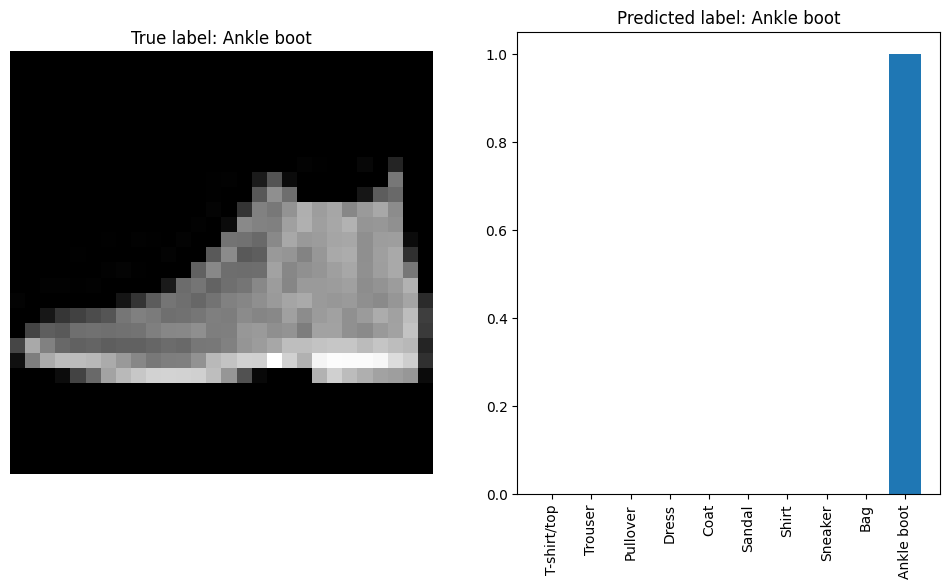

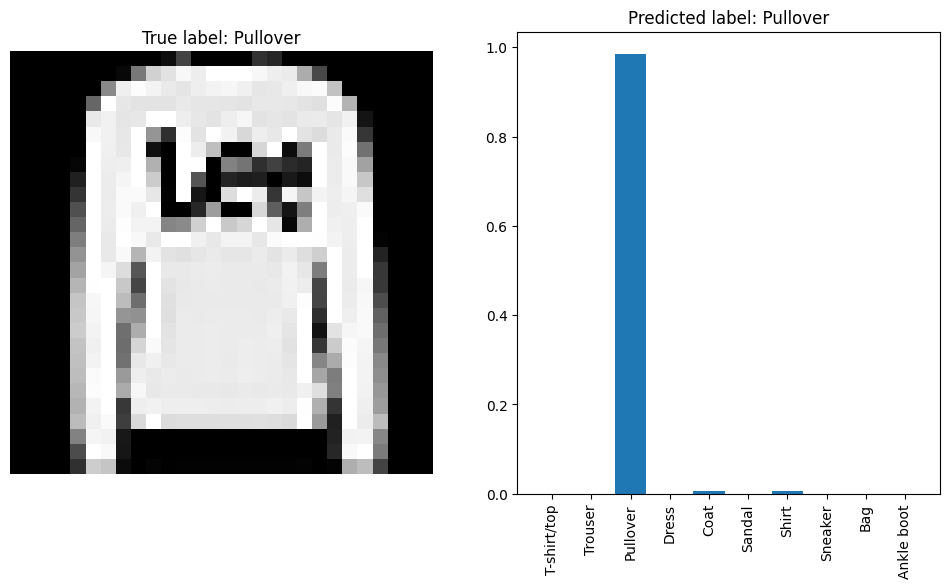

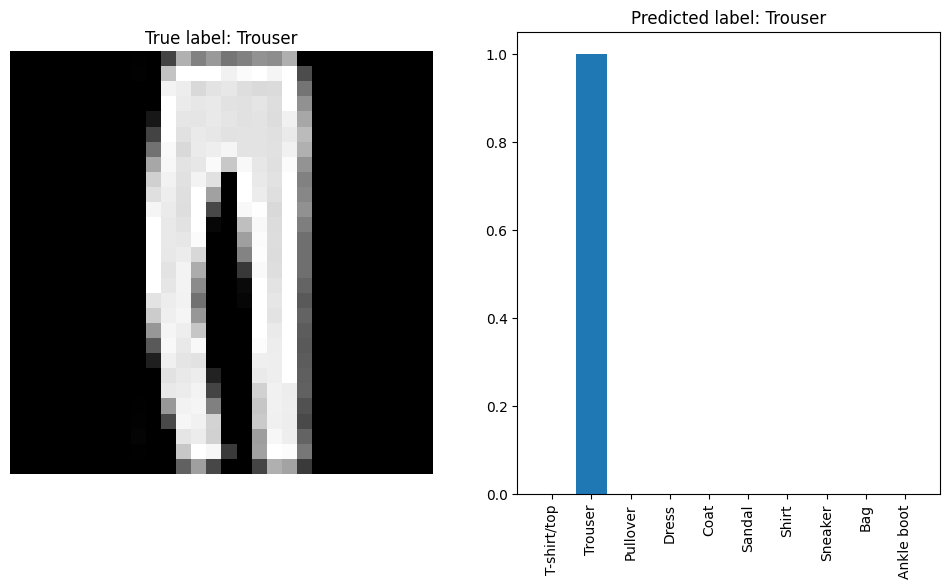

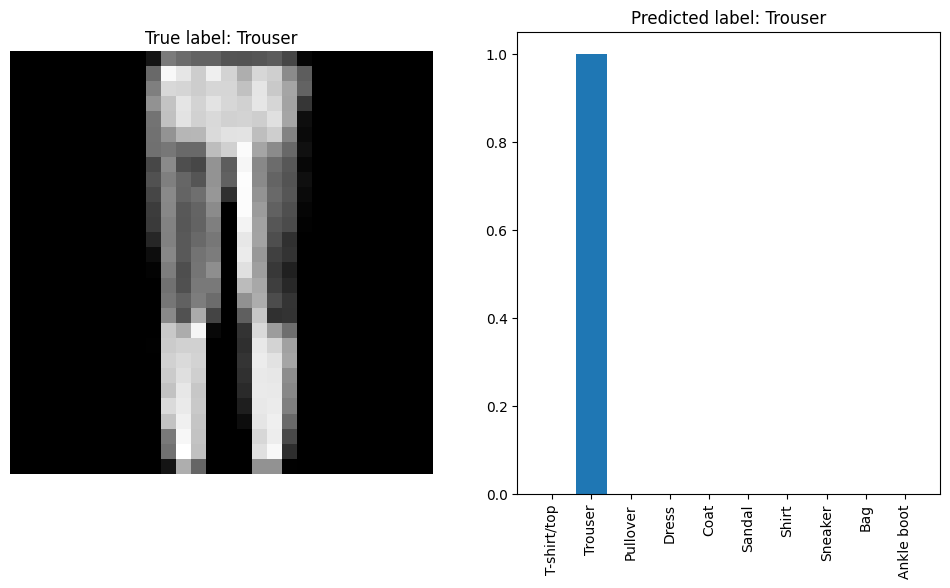

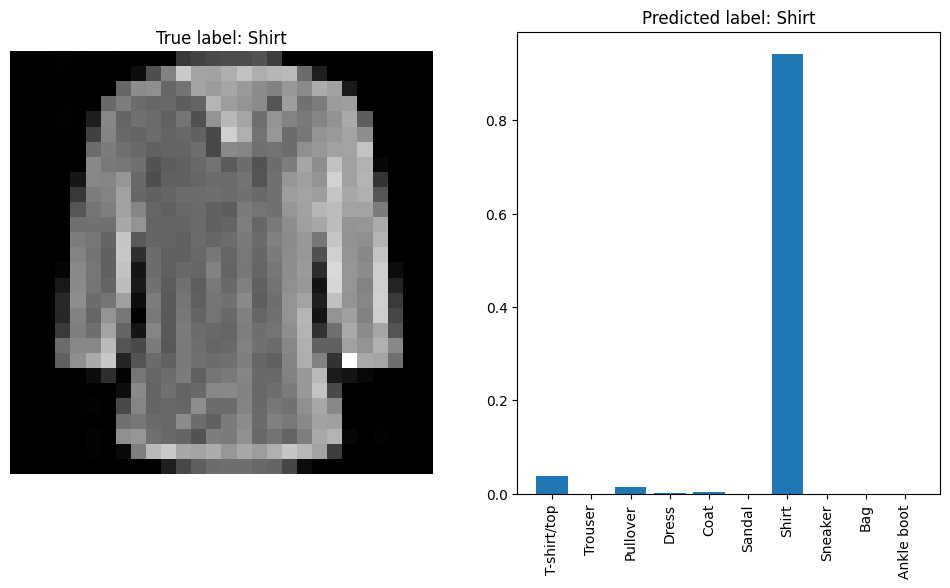

In [14]:
# validate the model by visualizing the prediction
images, labels = next(iter(test_loader))
labels_text = text_labels(labels)
results = net.to("cpu")(images).detach()
print(results.shape)
for i in range(images.shape[0]):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    ax1.imshow(images[i].squeeze(0), cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"True label: {labels_text[i]}")
    ax2 = fig.add_subplot(122)
    possibilities = nn.Softmax(dim=1)(results).detach()
    ax2.bar(range(10), possibilities[i])
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(text_labels(range(10)), rotation=90)
    ax2.set_title(f"Predicted label: {text_labels(possibilities[i].argmax())}")
    plt.show()